# Introduction
브라질에서 세번째로 큰 보험 회사인 Porto Seguro에 의해 주최된 이 대회는 운전자가 내년에 보험 청구를 할 가능성에 대해 예측하는 작업을 진행합니다.

이 노트북은 파이썬의 시각화 도구인 Plot.ly를 활용하여 상호관계적 차트를 만들고 데이터를 분석하는데 목적을 두고 있습니다. Plot.ly는 통계적 시각화에 특화된 라이브러리로 파이썬뿐만 아니라 다른 프로그래밍 언어에서도 사용하고 있습니다.

우리는 Plot.ly를 통하여 편리하게 다양한 그래프들을 만들어볼 수 있습니다.
1. Simple Horizontal bar plot: 단순 수평 막대그래프
2. Correlation Heatmap plot: 상관관계 히트맵
3. Scatter Plot: 산점도
4. Vertical Bar plot: 수직 막대 그래프
5. 3D Scatter Plot: 3D 산점도

이 노트북의 테마는 다음과 같이 정리할 수 있습니다:
1. 데이터 품질 점검: 결측치를 시각화하고 평가합니다.
2. Feature 점검과 필터링: 

  - 상관관계와 상호의존정보를 활용합니다. 
  - Binary, Categorical 그리고 다른 변수들을 점겁합니다.

3. 학습한 모델을 활용한 Feature 중요도 랭킹 산정

  - RandomForest와 Gradient Boosting을 활용하여 모델을 만듭니다.
  - 학습 과정에 기반하여 Feature들의 중요도 순위를 산정합니다.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
warnings.filterwarnings('ignore')

from collections import Counter
from sklearn.feature_selection import mutual_info_classif

- `plotly.offline`: 만들어진 그래프를 시각화합니다.
- `plotly.graph_objs`: 그래프를 선택하고 데이터와 레이아웃을 설정합니다.
- `plotly.tools`: 이번 노트북에서 사용하지 않습니다.

In [2]:
train = pd.read_csv('/content/drive/MyDrive/Porto Seguro’s Safe Driver Prediction/train.csv')
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


In [5]:
# train 데이터의 행과 열의 갯수를 확인합니다.
rows = train.shape[0]
columns = train.shape[1]

print('Train 데이터셋은 {}행 {}열 입니다.'.format(rows, columns))

Train 데이터셋은 595212행 59열 입니다.


# Data Quality checks

결측치을 찾아봅시다.

In [4]:
# 1. 데이터 퀄리티 체크

# 방법 1 any().any() 활용
print(train.isnull().any().any())

# 방법 2 sum().sum() 활용
print(train.isnull().sum().sum())

False
0


- 원본 작성자는 `any().any()`를 활용했지만, 개인적으로는 `sum().sum()`이 더 낫다고 생각해서 번역본에 넣었다고 합니다.

- 결측치가 전혀 없는 듯하지만 데이터 설명에 따르면 결측치가 -1로 처리가 되어있음을 알 수 있습니다. 따라서 -1값을 NaN값으로 치환해보도록 하겠습니다.

In [7]:
train_copy = train
train_copy = train_copy.replace(-1, np.NaN)

count_null = train_copy.isnull().sum().sum()
print('치환된 Null값의 갯수는 {}개입니다.'.format(count_null))

치환된 Null값의 갯수는 846458개입니다.


- 치환된 Null값의 갯수를 확인했습니다.
- 이제 Missingno 패키지를 활용하여 결측치를 확인해보도록 하겠습니다.

<AxesSubplot:>

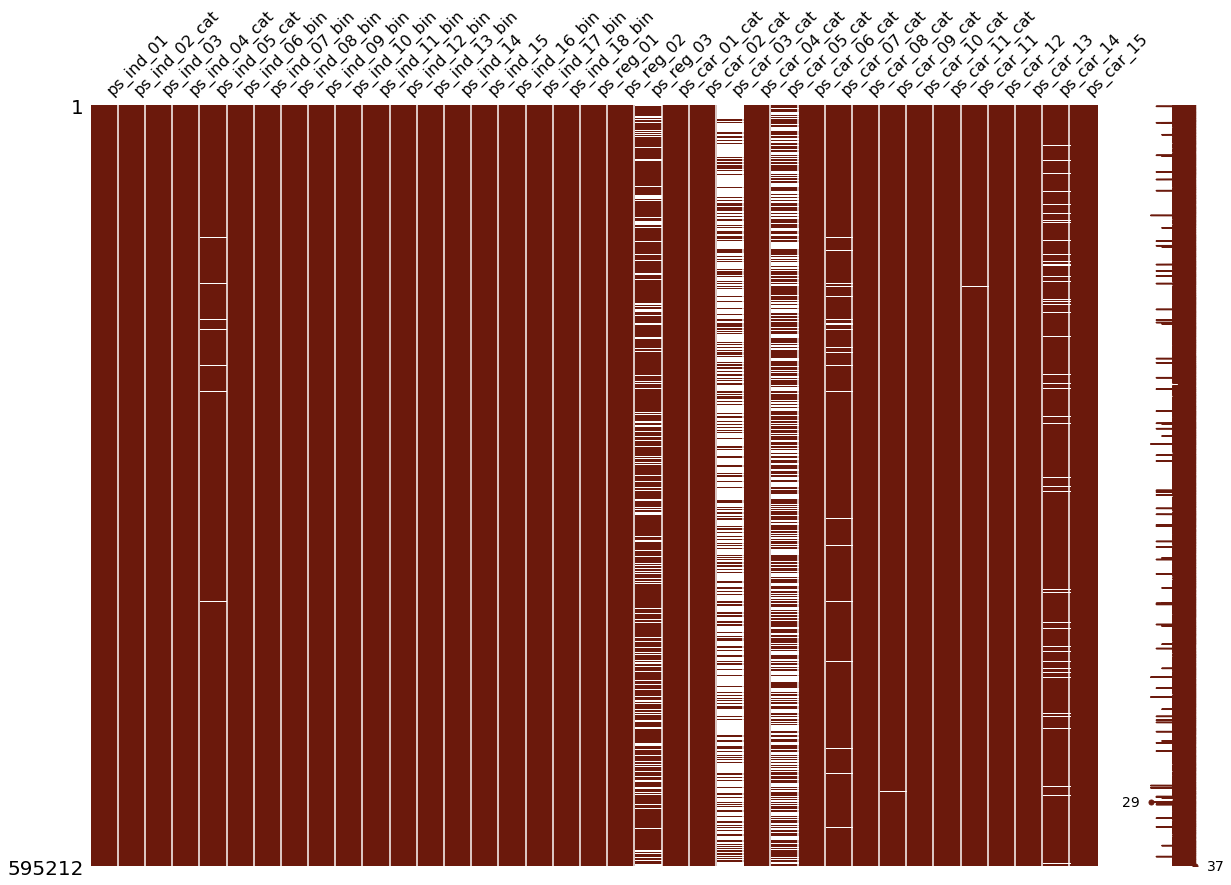

In [8]:
# missingno를 활용하여 Null값 확인하기
import missingno as msno
msno.matrix(df=train_copy.iloc[:,2 :39],
            figsize=(20,14), color=(0.42,0.1,0.05))

- 와인색 부분은 데이터가 온전히 보존된 부분이고 흰색 부분은 데이터가 유실된 부분을 나타냅니다.

- 이를 통해 우리는 59개의 Feature들 중 7개의 Feature에 결측값이 있음을 확인할 수 있습니다.

- 하지만 엄밀히 따지면 총 13개의 Feature에 결측값이 있습니다.
- Missingno 매트릭스는 대략 40개의 Feature들에 맞추어져 있기 때문에 제외된 Feature들에서 결측치를 지닌 남은 5개의 Feature들이 발견됐을 것입니다.

우리가 발견한 7개의 column은 다음과 같습니다:

ps_ind_05_cat/ ps_reg_03/ ps_car_03_cat/ ps_car_05_cat/ ps_car_07_cat/ ps_car_09_cat/ ps_car_14

- 많은 결측치를 가진 column은 '_cat'이라는 접미사를 지니고 있습니다. 

- 원본 노트북에는 없지만 결측치의 비율을 한 번 확인해봅시다.

In [10]:
# Null값의 percentage를 확인

for col in train_copy:
  if train_copy[col].isnull().sum() > 0:
    print('{}은 {}개의 Null값을 가지고 있다({:.2f}%)'.format(col, train_copy[col].isnull().sum(),
                                                  train_copy[col].isnull().sum()/len(train_copy[col])))

ps_ind_02_cat은 216개의 Null값을 가지고 있다(0.00%)
ps_ind_04_cat은 83개의 Null값을 가지고 있다(0.00%)
ps_ind_05_cat은 5809개의 Null값을 가지고 있다(0.01%)
ps_reg_03은 107772개의 Null값을 가지고 있다(0.18%)
ps_car_01_cat은 107개의 Null값을 가지고 있다(0.00%)
ps_car_02_cat은 5개의 Null값을 가지고 있다(0.00%)
ps_car_03_cat은 411231개의 Null값을 가지고 있다(0.69%)
ps_car_05_cat은 266551개의 Null값을 가지고 있다(0.45%)
ps_car_07_cat은 11489개의 Null값을 가지고 있다(0.02%)
ps_car_09_cat은 569개의 Null값을 가지고 있다(0.00%)
ps_car_11은 5개의 Null값을 가지고 있다(0.00%)
ps_car_12은 1개의 Null값을 가지고 있다(0.00%)
ps_car_14은 42620개의 Null값을 가지고 있다(0.07%)


앞서 언급했듯이 13개의 column들이 존재함을 알 수 있습니다.

## Target 변수 검사

- 표준화 검사 과정엔 Target Variable에 대한 검사가 수행됩니다.
- 이번 데이터의 경우에는 이미 Target Variable이 'Target'이라는 이름으로 지정되어 있습니다.
- 이 Target Variable은 class/label/correct라는 별칭으로 불리기도 하며 이를 바탕으로 새로운 데이터 값이 주어졌을 때 미지의 값을 예측하게 됩니다.

In [12]:
# 타겟 변수를 확인
data = [go.Bar(x=train['target'].value_counts().index,
               y=train['target'].value_counts().values,
               text = 'Distribution of target variable')]

layout = go.Layout(title='Target variable distribution')

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

matplotlib과 seaborn이 아닌 **Plot.ly**로 그래프를 그려봤습니다.

과정은 다음과 같이 진행됐습니다:
1. `go.Bar`를 활용하여 x축과 y축 데이터를 지정해줍니다. text는 그래프에 마우스를 올렸을 때 나타나는 텍스트를 의미합니다.
2. `go.Layout`을 활용하여 그래프의 제목을 지정해줍니다.
3. `go.Figure`를 활용하여 fig에 그래프를 할당해줍니다.
4. `py.iplot`을 활용하여 그래프를 시각화해줍니다.

여기서 go는 plotly.graphic_objs, iplot은 plotly.offline이었습니다.

시각화된 데이터를 보니 레이블값이 매우 불균형함을 알 수 있습니다.

## Datatype check

- 이 과정을 통해 훈련 데이터가 어떤 데이터들로 구성되어 있는지 확인해봅니다.
- 정수인지, 문자인지, 실수인지 확인함으로써 데이터에 대해 더 나은 전반적인 이해를 얻을 수 있습니다.
- Collections 모듈의 Counter를 활용하여 확인해보도록 합니다.

In [13]:
# Train 데이터의 타입 확인 (방법1)
train.dtypes.value_counts().to_frame() # 시리즈 to 데이터프레임

,0
int64,49
float64,10


In [14]:
# Train 데이터의 타입 확인 (방법2)
Counter(train.dtypes.values)

Counter({dtype('int64'): 49, dtype('float64'): 10})

- 49개로 이루어진 column들은 49개의 int, 20개의 float으로 구성되어 있습니다.
- 각 데이터들은 '_bin', '_cat', '_reg'라는 접미사를 가지고 있습니다.
- 각각의 접미사들은 뜻을 가지고 있는데, '_bin'은 binary, '_cat'은 categorical, '_reg'는 Continuous이거나 Ordinal 데이터를 말합니다.

이제 단순히 float values(Continuous Feature)와 integer values(Binary, Categorical, Ordinal)으로 데이터를 나눠보도록 합시다.


In [15]:
# float와 int를 select_dtypes를 활용하여 구분
train_float = train.select_dtypes(include=['float64'])
train_int = train.select_dtypes(include='int64') 

**DataFrame.select_dtypes(include=None, exclude=None)**

- `select_dtypes` 함수는 열에 포함된 데이터들을 type 기준으로 인덱싱할 수 있도록합니다.
- `select_dtypes(include=None, exclude=None)`형태를 가지며, include에 넣은 값을 포함하고 exclude에 넣은 값을 제외한 columns(열)을 DataFrame형태로 반환합니다.
- 자료형
  - 숫자형(numeric)은 np.number 또는 'number'
  - 문자형(str)은 'object'
  - 날짜, 시간(datetimes)을 선택하려면 np.datetime64, 'datetime' 또는 'datetime64'
  - timedeltas는 np.timedelta64, 'timedelta', 'timedelta64'
  - Pandas의 categorical 타입은 'category'

## Correlation plots

- 변수들의 선형 상관관계 그래프를 확인해봄으로써 인사이트를 얻어보도록 하겠습니다.
- 일단 seaborn 라이브러리를 활용하여 히트맵을 그려보도록 합시다.
- 편리하게 pandas의 `corr()`을 사용하여 피어슨 상관계수를 계산해준 뒤, seaborn의 heatmap을 사용해보도록 합시다.

### float features들의 상관관계

<AxesSubplot:title={'center':'Pearson correlation of continuous features'}>

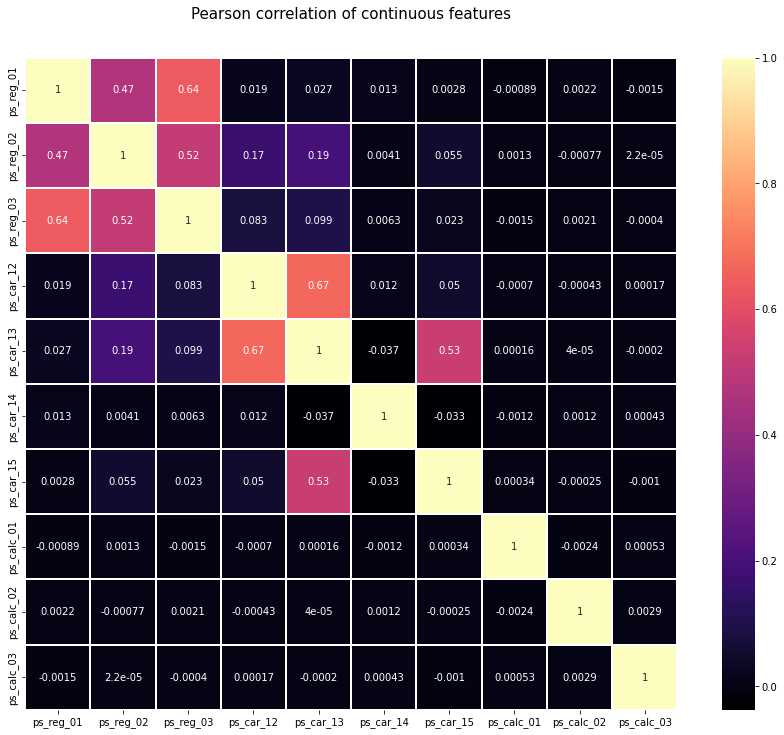

In [16]:
# seaborn을 활용하여 float 데이터의 히트맵 생성
colormap = plt.cm.magma
plt.figure(figsize=(16,12))
plt.title('Pearson correlation of continuous features', y=1.05, size=15)
sns.heatmap(train_float.corr(), 
            linewidths=0.1, # 셀 사이에 선을 집어 넣는다.
            vmax=1.0, square=True, cmap=colormap, 
            linecolor='white', # 각 셀을 나누는 선의 색상
            annot=True)

- 히트맵을 통해 대다수의 feature들이 0이거나 다른 변수들과 상관관계가 거의 없음을 확인 가능합니다.
- 이것은 추가로 할 조사에 흥미로운 관찰 결과를 말해줍니다.
- 지금 당장에는, 양의 상관관계를 보이는 변수들은 다음과 같습니다:
  - (ps_reg_01, ps_reg_03)
  - (ps_reg_02, ps_reg_03)
  - (ps_car_12, ps_car_13)
  - (ps_car_13, ps_car_15)

## Interget Feature들의 상관관계

- 이번에는 seaborn 대신 plotly를 사용해보도록 하겠습니다.
- 간단하게 `go.Heatmap`을 사용하면 됩니다. 
- x축과 y축에는 각 column의 이름들을 기입해주고 z축에는 상관관계 값을 기입해줍니다.

In [21]:
data =[
    go.Heatmap(
        z=train_int.corr().values, # 상관관계값
        x=train_int.columns.values, # columns
        y=train_int.columns.values, # columns
        colorscale='Viridis',
        reversescale=False, # 색상 맵핑을 반전, zmin은 배열의 마지막색에 해당하고 zmax는 첫 번째 색에 해당함
        opacity=1.0 # 불투명도 설정
    )
]

layout = go.Layout(
    title='Pearson corr of Integer-type Features',
    xaxis=dict(ticks='',  # 눈금을 그릴지 여부를 결정, ''인 경우 축의 눈금을 그리지 않음
               nticks=36 ), # 특정 축의 최대 눈금 수를 지정
    yaxis=dict(ticks=''),
    width=900, height=700
    )
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

- 비슷하게, 대다수의 column들이 상관관계를 가지고 있지 않거나 0임을 확인 가능합니다.
- 이 정보는 만약 우리가 주성분 분석(PCA)과 같이 차원 축소를 진행하는 경우에 매우 유용한 정보가 될 수 있습니다.
- 우리에게 흥미로운 column은 다음과 같습니다:
  - 음의 상관관계를 가지는 Features:
    - ps_ind_06_bin
    - ps_ind_07_bin
    - ps_ind_08_bin
    - ps_ind_09_bin
- 또 다른 흥미로운 측면은 우리가 결측치 분석에서 많은 결측치를 지녔던 ps_car_03_cat과 ps_car_05_cat에서 찾아볼 수 있습니다.
- 우리는 이 둘이 강력한 양의 상관을 가지고 있어도 놀라울 일이 아니지만 데이터에 대한 근본적인 진실을 제대로 반영하지 못하고 있을 수 있습니다.

## Mutual Information plots

- 상호의존정보는 Target과 변수들 간의 상호 정보를 검사할 수 있는 유용한 도구입니다.
- 분류 문제에서, 우리는 sklearn의 `mutual_info_classif` 메소드로 손쉽게 이를 측정할 수 있습니다.
- 0일 경우 랜덤한 변수가 서로 독립적이라는 것을 의미하며, 값이 높아질수록 약간의 독립성을 나타냅니다.
- 이 기능을 통해 feature 내부에 target에 대한 정보가 얼마나 담겨있는지 알 수 있습니다.

In [22]:
# 상호의존정보 확인
mf = mutual_info_classif(train_float.values, # X: feature matrix
                         train['target'].values, # y: Target vector
                         n_neighbors=3, # mutual information 이웃 수/ 값이 클수록 추정의 분산이 감소하지만 치우침이 발생할 수 있다.
                         random_state=17)
print(mf)

[0.02599971 0.00767074 0.00617141 0.01855302 0.00158483 0.00338192
 0.01668813 0.0134428  0.01334669 0.01348572]


## Binary features inspection

- 다음으로는 0과 1, 두 개의 값만을 가지고 있는 binary columns들에 대한 검사를 시작합니다.
- 모든 binary column을 호출하여 0과 1의 비율을 그래프로 나타내보도록 합시다.

In [23]:
bin_col = []
for col in train.columns:
  if '_bin' in col:
    bin_col.append(col)

zero_list=[]
one_list=[]

for col in bin_col:
  zero_list.append((train[col]==0).sum())
  one_list.append((train[col]==1).sum())

In [24]:
trace1 = go.Bar(
    x=bin_col,
    y=zero_list,
    name='Zero count' # trace 이름이 범례 항목으로 표시되고 호버에 표시됨
)

trace2 = go.Bar(
    x=bin_col,
    y=one_list,
    name='One Count'
)

data = [trace1, trace2]

layout = go.Layout(
    barmode='stack',
    title='Count of 1 and 0 in binary variables'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig)

- ps_ind_10_bin, ps_ind_11_bin, ps_ind_12_bin, ps_ind_13_bin이 네 개의 column은 거의 완벽히 0에게 지배당했습니다.
- 이를 통해 target에 대한 정보가 거의 담기지 않았음을 유추할 수 있을 것입니다.

# RandomForest를 활용한 Feature importance 확인

- 이제 RandomForest 분류기로 train 데이터를 fit시키고, 모델이 훈련을 마친 후 특징의 순위를 살펴보는 RandomForest 모델을 구현하도록 합니다. 
- 이것은 유용한 feature importance를 얻는데 많은 하이퍼 파라미터 튜닝이 필요하지 않고 목표 불균형을 파악하는 데도 매우 강력한 앙상블 모델을 사용하는 빠른 방법입니다.

In [25]:
# RandomForest를 활용한 Feature Importance 확인
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=150,
                            max_depth=8,
                            min_samples_leaf=4,
                            max_features=0.2,
                            n_jobs=-1,
                            random_state=0)
X_train = train.drop(['target','id'],axis=1)
y_train = train['target']

rf.fit(X_train, y_train)

features = train.drop(['target', 'id'],axis=1).columns.values

print('훈련 완료')

훈련 완료


## Plot.ly Scatter Plot

- 훈련된 RandomForest 모델은 'feature importances'로 값을 불러올 수 있습니다.
- 그렇다면 plotly의 Scatter plot으로 이를 확인해보도록 합시다. 
- 한가지 주의해야 할 점은 scatter plot의 Marker 속성입니다. 
- 이를 통해 사이즈, 색상, 스케일 등을 조정할 수 있습니다.

In [26]:
trace = go.Scatter(
    y = rf.feature_importances_,
    x= features,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size =13,
        color = rf.feature_importances_,
        colorscale='Portland',
        showscale=True
    ),
    text=features
)
data = [trace]

layout = go.Layout(
    autosize= True,
    title = 'Random Forest Feature Importance',
    hovermode = 'closest',
    xaxis = dict(
        ticklen= 5,
        showgrid= False,
        zeroline= False,
        showline= False
    ),
    yaxis=dict(
        title= 'Feature Importance',
        showgrid= False,
        zeroline= False,
        ticklen= 5,
        gridwidth=2
    ),
    showlegend= False
)
fig= go.Figure(data=data, layout=layout)
py.iplot(fig, filename='scatter2010')

막대 그래프 형태로도 살펴보도록 합시다.

In [27]:
x, y = (list(x) for x in zip(*sorted(zip(rf.feature_importances_, features),
                                     reverse= False)))
trace2 = go.Bar(
    x=x,
    y=y,
    marker=dict(
        color=x,
        colorscale='Viridis',
        reversescale= True
    ),
    name = 'Random Forest Feature importance',
    orientation='h',
)

layout = dict(
    title='Barplot of Feature importances',
    width = 900, height=2000,
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True
    ))

fig1 = go.Figure(data=[trace2])
fig1['layout'].update(layout)
py.iplot(fig1, filename='plots')

## Gradient Boosting을 통한 Feature Importance 확인

다른 모델을 활용하여 Feature Importance를 얻어보도록 합시다.

In [29]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(n_estimators=100,
                                max_depth=3,
                                min_samples_leaf=4,
                                max_features=0.2,
                                random_state=0)

gb.fit(X_train, y_train)

print('훈련 완료')

훈련 완료


In [30]:
trace = go.Scatter(
    y=gb.feature_importances_,
    x=features,
    mode='markers',
    marker=dict(
        sizemode='diameter', # marker사이즈가 숫자 배열로 설정된 경우에만 효과가 있음, 크기의 데이터를 픽셀로 변환하는 규칙 설정
        sizeref = 1, # 마커 점의 렌더링 크기를 결정하는데 사용되는 축척 계수
        size =13, # 마커 사이즈 
        color = gb.feature_importances_,# 오류 표시줄의 색상 설정
        colorscale = 'Portland',
        showscale = True # 색상 막대 표시 여부 결정
    ),
    text = features
)

data = [trace]

layout = go.Layout(
    autosize=True, # 사용자가 정의하지 않은 레이아웃 너비 또는 높이를 각 레이아웃에서 초기화할지 여부를 결정
    title= 'Gradient Boosting Machine Feature Importance', # 제목
    hovermode= 'closest', # hover 상호 작용 모드 결정. closest경우, 호버 거리 내의 가장 가까운 지점에 대해 단일 호버 레이블이 나타남
    xaxis=dict(
        ticklen=5,
        showgrid=False,
        zeroline=False,
        showline=False
    ),
    yaxis=dict(
        title='Feature Importances', # 제목
        showgrid=False, # 그리드 선을 그릴지 여부를 결정, True이면 눈금마다 그리드 선이 그려짐
        zeroline=False, # 축의 0값을 따라 선이 그려지는지 여부를 결정. True이면 그리드 선위에 0선이 그려짐
        showline=False, # 축을 경계롤 하는 선을 그릴지 여부를 결정
        ticklen= 5, # 스텝 눈금의 길이를 픽셀 단위로 설정
        gridwidth= 2 # grid선의 너비(픽셀 단위)를 설정
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

In [32]:
x, y = (list(x) for x in zip(*sorted(zip(gb.feature_importances_, features),
                             reverse=False)))
trace2 = go.Bar(
    x=x,
    y=y,
    marker=dict(
        color=x,
        colorscale= 'Viridis',
        reversescale= True
    ),
    name= 'Random Forest Feature importance',
    orientation='h' # 막대 방향 설정, 'v('h')'를 사용하면 각 막대의 값은 수직(수평)을 따라 확장
)

layout = dict(
    title='Barplot of Feature importances',
    width=900, height=2000,
    yaxis=dict(
        showgrid= False,
        showline= False,
        showticklabels= True
    ))

fig1 = go.Figure(data=[trace2])
fig1['layout'].update(layout)
py.iplot(fig1, filename='plots')

흥미롭게도 두 모델 모두에게서 ps_car_13이 제일 중요한 column임을 확인할 수 있었습니다.

# 참고

https://www.kaggle.com/code/sihwanyoon/interactive-porto-insight

https://wikidocs.net/151224

https://dsbook.tistory.com/51

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html